<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

# Group members

**Minimum 2, Maximum 3**

* KHUONG Thanh Gia Hieu
* ISPAS Alex-Răzvan
* BHATT Ragi


# Presentation of the challenge

## Main question of this challenge

* How to predict the survival of a patient according to their medical files and physiological data?
    
* Specifically, you will need to predict it during their hospital stay
 
Every day, the nursing staff collects information about the patients by asking questions and using measurement tools (stethoscope, blood test, sensors, etc.). These data are very useful for monitoring the state of health, diagnosing, and choosing treatments.

They can also be used for predictive statistical analysis.

## Data

The dataset contains information on 80,000 patients, represented by categorical, binary and, numeric variables (features). These variables are, e.g., age, sex, ethnicity, marital status, as well as medical data such as blood pressure or glucose level. There are a total of 342 variables.

The class to predict is a binary variable indicating whether the patient died or not during his stay in the hospital. Fortunately, most survive:

<!-- #%%[markdown] -->
# ![](img/tobe.png)

References and credit:

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

The link to the challenge:
<https://codalab.lisn.upsaclay.fr/competitions/8802>

* **Step 1:** Register an acount at <https://codalab.lisn.upsaclay.fr>

* **Step 2:** Download the dataset from the [page](https://codalab.lisn.upsaclay.fr/competitions/328#participate-get_starting_kit) `Participate` > `Files` > `Public Data`. Place the `public_data` folder in the same folder as the one containing this notebook.

* **Step 3:** Go through this notebook. You will have to read, execute, **code your own methods** and **answer questions**. Use the ***code*** cell for coding and the ***markdown*** cell to answer questions.

## Project evaluation

* **4 points**: Exploratory analysis

* **4 points**: Clean and well-documented code

* **4 points**: Modeling (selection of the model, selection of hyperparameters)

* **4 points**: Evaluation of the performance of the model

* **4 points**: Quality of the oral presentation

### FAQ

* Submit only the notebook to eCampus (**only 1 per team**)

* The text answers (explanations, results, problems, without the code) must not exceed 1500 words

# Challenge

In [1]:
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import gc
import tqdm
import re
from collections import defaultdict

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import EasyEnsembleClassifier,BalancedRandomForestClassifier
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

In [2]:
%reload_ext autoreload
%autoreload 2

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.1.3

1.1.2


## 1. Understanding the problem

### Metric

Why the metric used here is the [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) rather than simply [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)?

balanced_accuracy_score is a very important metric when we want to evaluate on imbalance data. Not just for this competition, but also in anomaly detection like working on a fraudulent transaction dataset, we know most transactions would be legal, i.e the ratio of fraudulent to legal transactions would be small, balanced accuracy is a good performance metric for imbalanced data like this.

## 2. Data loading

In [3]:
def load_data():
    DATA = Path("public_data")
    assert DATA.is_dir()

    PRED_PATH = Path("Submissions")

    DROP_FTS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

    features = pd.read_csv(
        DATA / "mimic_synthetic_feat.name", header=None
    ).values.flatten()

    labels = pd.read_csv(
        DATA / "mimic_synthetic_label.name", header=None
    ).values.flatten()

    x_df = pd.read_csv(
        DATA / "mimic_synthetic_train.data",
        header=None,
        names=features,
        sep=" ",
    )

    # Remove variables that are not relevant
    x_df.drop(columns=DROP_FTS, inplace=True)

    ys = pd.Series(
        pd.read_csv(
            DATA / "mimic_synthetic_train.solution",
            header=None,
            names=labels,
            sep=" ",
        ).values.flatten()
    )
    # Load test set
    x_test_df = pd.read_csv(
        DATA / "mimic_synthetic_test.data",
        header=None,
        names=features,
        sep=" ",
    )

    # Remove variables that are not relevant
    x_test_df.drop(columns=DROP_FTS, inplace=True)

    features = np.delete(features, np.where(np.isin(features, DROP_FTS)))

    return x_df, ys, x_test_df, features


In [4]:
x_df, ys, x_test_df, features = load_data()
x_df

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,75,83.78,89.19,86.05,...,0,0,0,0,0,0,0,0,1,0
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,55,60.88,105.6,80.62,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,Medicare,ENGL,NOT_SPECIFIED,UNKNOWN_(DEFAULT),WHITE,F,76,56.04,97.86,79.71,...,0,0,0,0,0,0,0,0,1,0
79995,Medicaid,ENGL,JEWISH,MARRIED,WHITE,F,38,55.13,86.03,67.65,...,0,0,0,0,0,1,0,0,0,0
79996,Private,ENGL,NOT_SPECIFIED,SEPARATED,WHITE,F,90,74.28,91.27,91.43,...,0,0,0,0,0,0,0,0,0,0
79997,Government,ENGL,CATHOLIC,MARRIED,BLACK/AFRICAN_AMERICAN,M,57,79.26,129,98.74,...,0,0,0,0,0,0,0,0,1,0


This is **the training set**. This means that you have access to the labels and can use it however you want to prepare your model.

Later, you will have your model draw predictions from **the test set** in order to upload them to Codalab and get a score on data not seen while training the models.

## 3. Exploratory analysis

#### Features' types

In [5]:
x_df.dtypes.value_counts()

int64      279
float64     51
object       7
dtype: int64

In [6]:
x_df.describe()

,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,DIAS_BP_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
count,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,...,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04
mean,62.66,71.65,103.1,86.39,94.61,147.8,119.7,45.24,81.99,60.84,...,0,1.25e-05,0,0,0,0.1455,0.1342,0.008625,0.4577,0.07898
std,18.19,14.65,18.48,15.51,16.94,21.61,16.49,10.5,16.64,10.27,...,0,0.003536,0,0,0,0.3526,0.3408,0.09247,0.4982,0.2697
min,16,18.73,49.86,38.5,31.77,91.69,73.97,11.33,42.43,30.5,...,0,0,0,0,0,0,0,0,0,0
25%,51,61.46,89.9,75.28,82.81,132.1,107.6,37.83,69.96,53.4,...,0,0,0,0,0,0,0,0,0,0
50%,65,71.05,101.6,85.42,94.17,145.4,118.1,44.62,79.86,60.1,...,0,0,0,0,0,0,0,0,0,0
75%,77,81.15,114.8,96.51,106,161.1,130.3,51.97,91.76,67.41,...,0,0,0,0,0,0,0,0,1,0
max,90,141.9,206.6,157.6,163.8,260,186.3,95.6,189,109.6,...,0,1,0,0,0,1,1,1,1,1


#### Target feature distribution

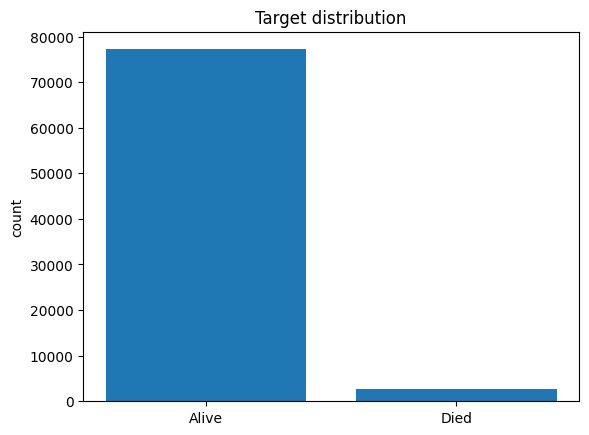

In [7]:
plt.bar(x=['Alive', 'Died'], height=ys.value_counts().to_numpy())
plt.ylabel('count')
plt.title('Target distribution')
plt.show()

### Code: Produce the following graphs

* Bar chart to show the target feature distribution

* Bar charts of 4 categorical variables (e.g., "LANGUAGE", "MARITAL_STATUS")

* Show the correlation between a selection of features and the target feature y

* Another graph or any exploratory analysis you can think of

### Categorical variables

In [8]:
x_df_with_target = x_df.copy()
x_df_with_target['target'] = ys

In [9]:
def plot_category_distribution(category, show_target_dist=True):
    plt.figure(figsize=(12,6))
    
    if show_target_dist:



        target_count = x_df_with_target.groupby([category, 'target']).target.count()
        cols_per_target, counts_per_target = defaultdict(list), defaultdict(list)
        for (col, target), count in target_count.items():
            cols_per_target[target].append(col)
            counts_per_target[target].append(count)

        dataset = np.array([counts_per_target[0], counts_per_target[1]])
  
        # Finding Chi-squared test statistic,
        # sample size, and minimum of rows
        # and columns
        X2 = stats.chi2_contingency(dataset, correction=False)[0]
        N = np.sum(dataset)
        minimum_dimension = min(dataset.shape)-1
        
        # Calculate Cramer's V
        cramerv = np.sqrt((X2/N) / minimum_dimension)

        
        plt.bar(x=cols_per_target[0], height=counts_per_target[0], label='Alive')
        plt.bar(x=cols_per_target[1], height=counts_per_target[1], bottom=counts_per_target[0], label='Died')
        plt.legend()
        plt.title(f"{category} distribution. Cramer's V correlation: {cramerv:.4f}")
    else:
        category_counts = x_df_with_target[category].value_counts()
        plt.bar(x=category_counts.index.values, height=category_counts.values)
        plt.title(f'{category} distribution')
        
    plt.ylabel('count')
    
    
    plt.show()

Male and Female have the same rate of death

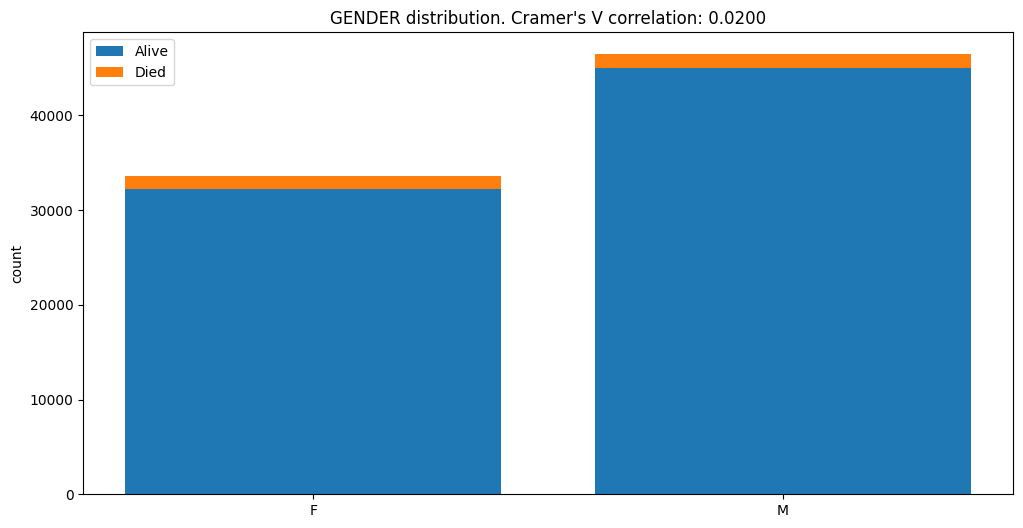

In [10]:
plot_category_distribution('GENDER')

More high age people participate in the dataset, but no clear correlation

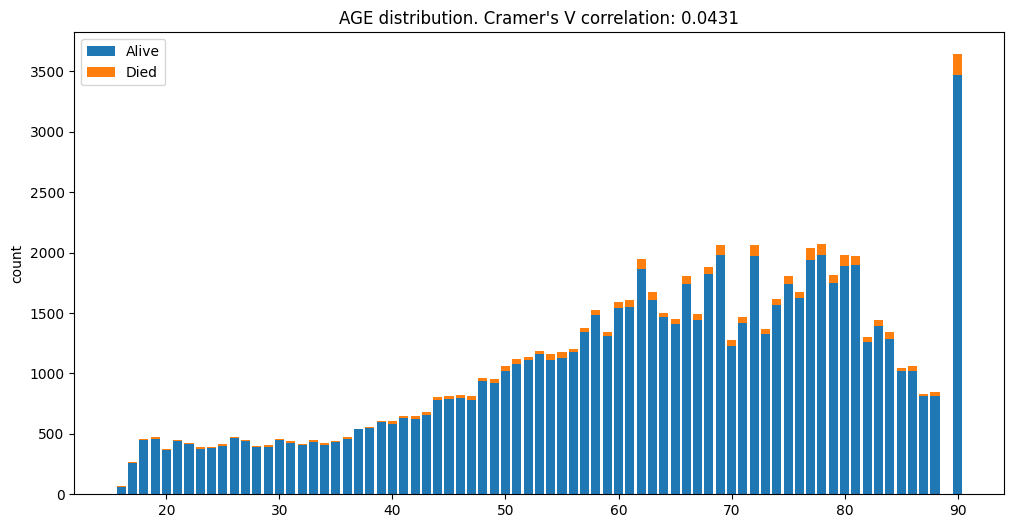

In [11]:
plot_category_distribution('AGE')

Marrital status shows MARRIED death rate is higher, but the same time because old people are mostly MARRIED

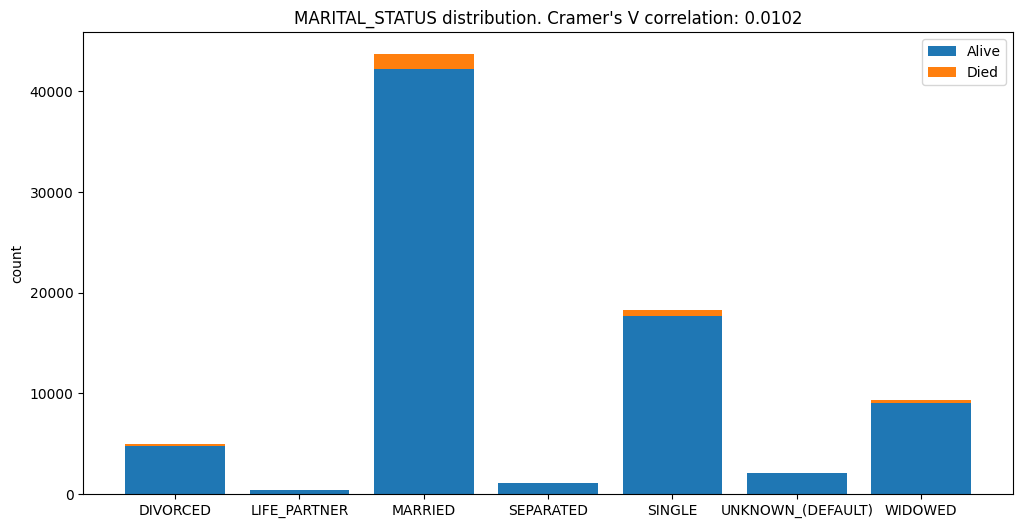

In [12]:
plot_category_distribution('MARITAL_STATUS')

Too many people speak English

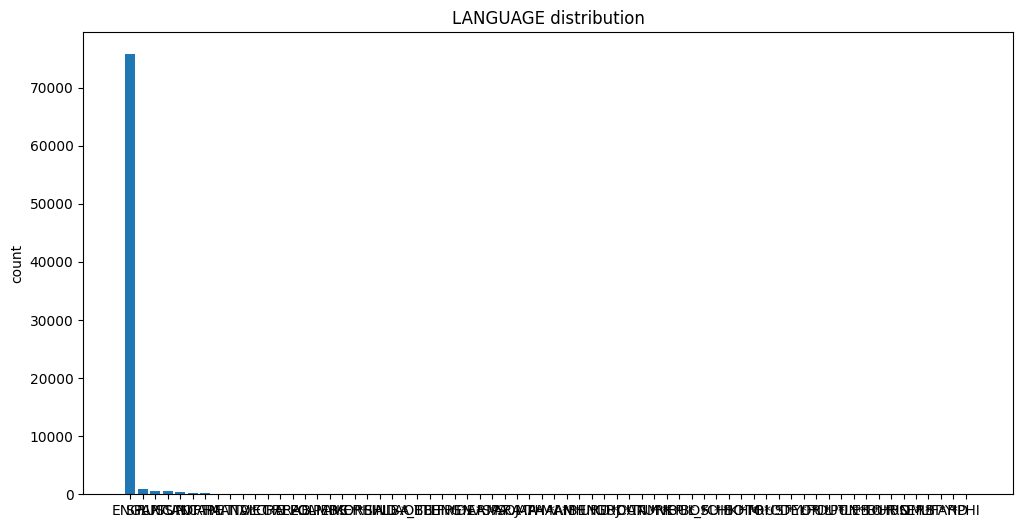

In [13]:
plot_category_distribution('LANGUAGE', show_target_dist=False)

Let's try to group non-english speaker together

In [14]:
x_df_with_target['LANGUAGE_GROUPED'] = x_df_with_target['LANGUAGE']
x_df_with_target.loc[x_df_with_target['LANGUAGE_GROUPED']!='ENGL', 'LANGUAGE_GROUPED'] = 'NON-ENGL'

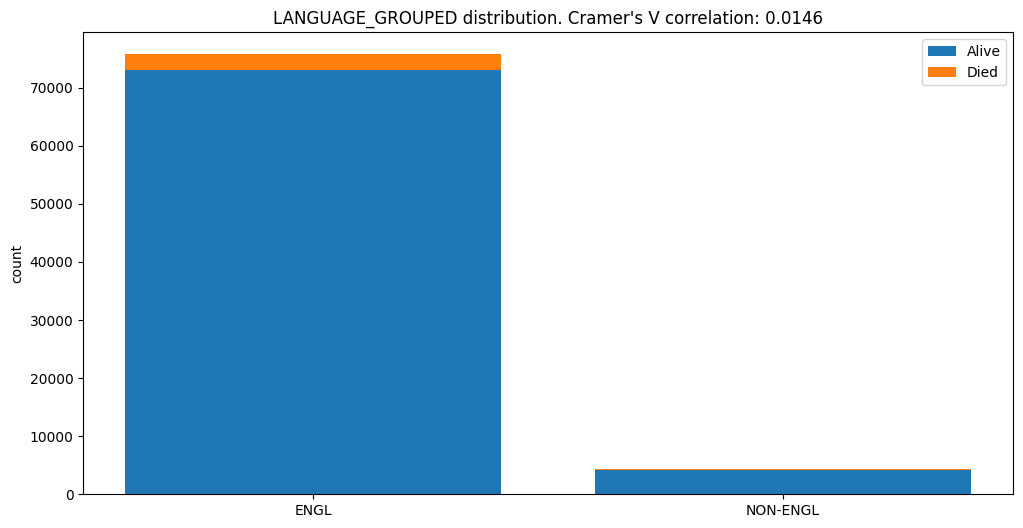

In [15]:
plot_category_distribution('LANGUAGE_GROUPED', show_target_dist=True)

So many speaking English is correlated to death?

### Other important features we found

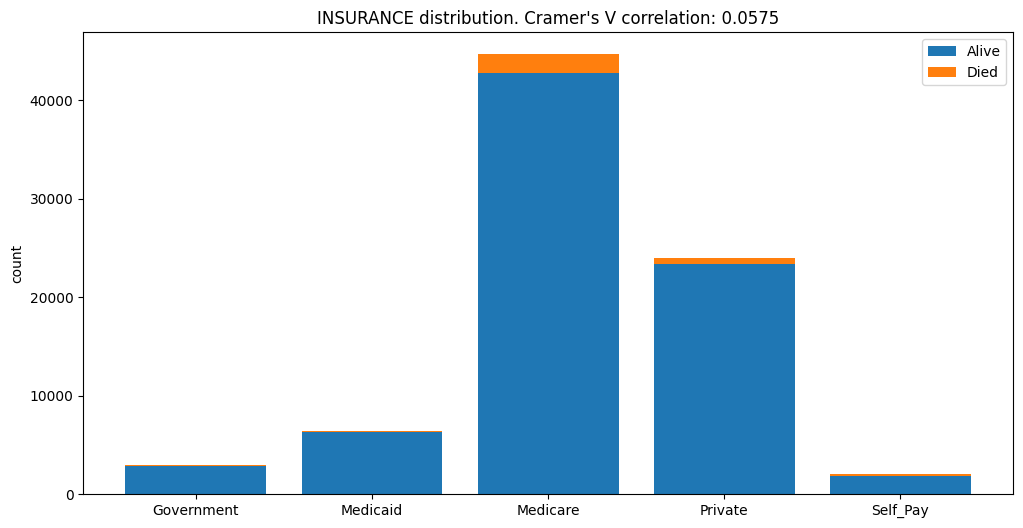

In [16]:
plot_category_distribution('INSURANCE')

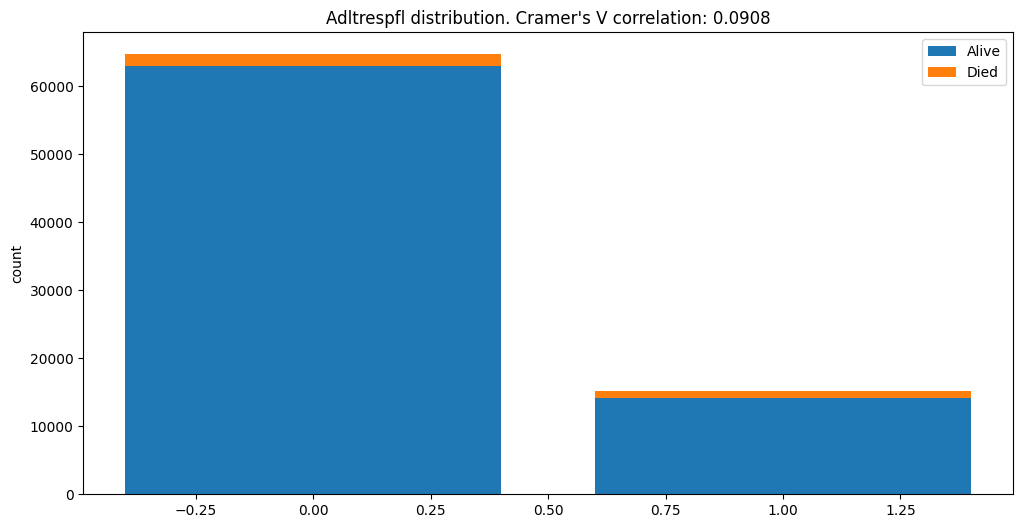

In [17]:
plot_category_distribution('Adltrespfl')

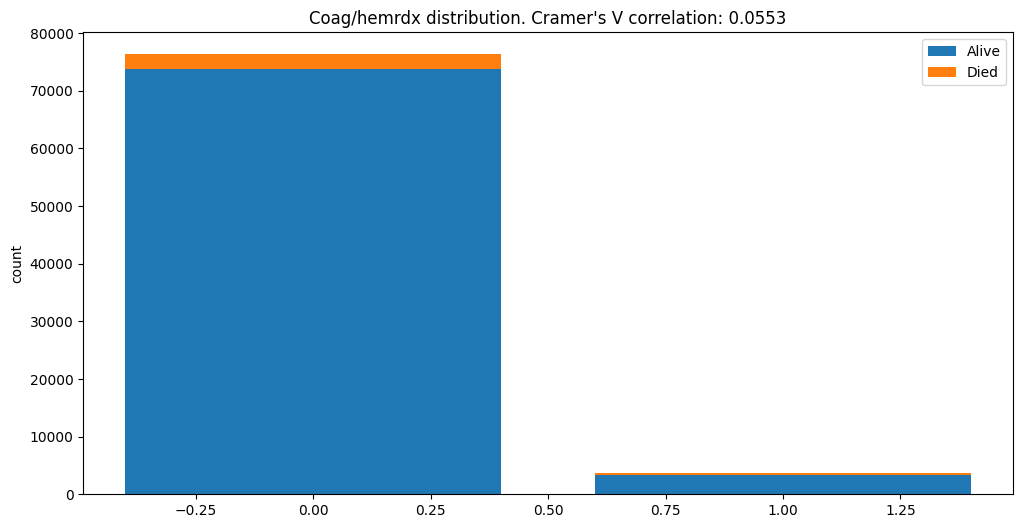

In [18]:
plot_category_distribution('Coag/hemrdx')

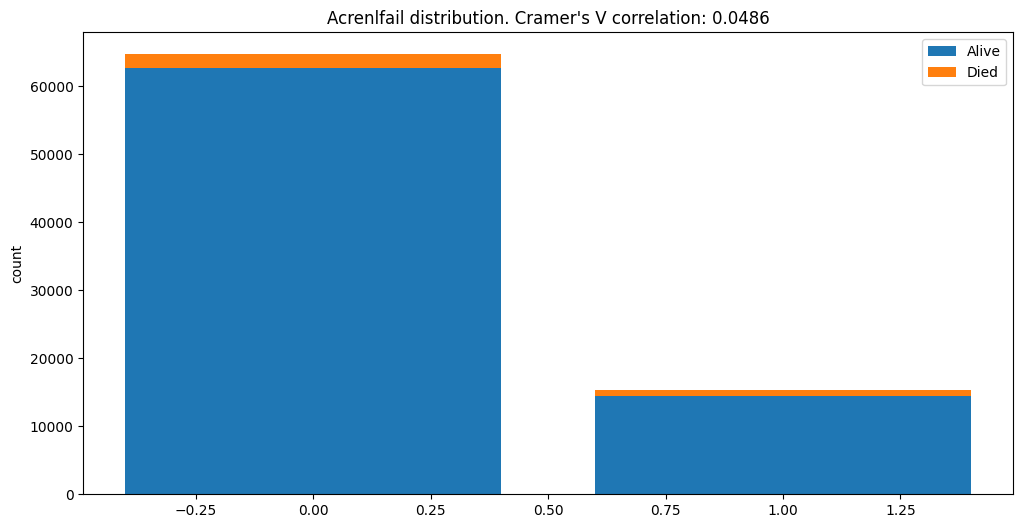

In [19]:
plot_category_distribution('Acrenlfail')

## 4. Preprocessing

In [20]:
NUMERIC_FTS = [
'AGE',
'HR_MIN_DAY1',
'HR_MAX_DAY1',
'HR_MEAN_DAY1',
'SYS_BP_MIN_DAY1',
'SYS_BP_MAX_DAY1',
'SYS_BP_MEAN_DAY1',
'DIAS_BP_MIN_DAY1',
'DIAS_BP_MAX_DAY1',
'DIAS_BP_MEAN_DAY1',
'MEAN_BP_MIN_DAY1',
'MEAN_BP_MAX_DAY1',
'MEAN_BP_MEAN_DAY1',
'RESP_RATE_MIN_DAY1',
'RESP_RATE_MAX_DAY1',
'RESP_RATE_MEAN_DAY1',
'TEMP_MIN_DAY1',
'TEMP_MAX_DAY1',
'TEMP_MEAN_DAY1',
'SPO2_MIN_DAY1',
'SPO2_MAX_DAY1',
'SPO2_MEAN_DAY1',
'GLUCOSE_MIN_DAY1',
'GLUCOSE_MAX_DAY1',
'GLUCOSE_MEAN_DAY1',
'HR_MIN_DAY2',
'HR_MAX_DAY2',
'HR_MEAN_DAY2',
'SYS_BP_MIN_DAY2',
'SYS_BP_MAX_DAY2',
'SYS_BP_MEAN_DAY2',
'DIAS_BP_MIN_DAY2',
'DIAS_BP_MAX_DAY2',
'DIAS_BP_MEAN_DAY2',
'MEAN_BP_MIN_DAY2',
'MEAN_BP_MAX_DAY2',
'MEAN_BP_MEAN_DAY2',
'RESP_RATE_MIN_DAY2',
'RESP_RATE_MAX_DAY2',
'RESP_RATE_MEAN_DAY2',
'TEMP_MIN_DAY2',
'TEMP_MAX_DAY2',
'TEMP_MEAN_DAY2',
'SPO2_MIN_DAY2',
'SPO2_MAX_DAY2',
'SPO2_MEAN_DAY2',
'GLUCOSE_MIN_DAY2',
'GLUCOSE_MAX_DAY2',
'GLUCOSE_MEAN_DAY2']

### Code: Missing values handling

#### Exploration

First check the number of missing data per features and per instances (patient). Don't forget to process both the training and the test sets!

In [21]:
x_df[x_df.isna().any(axis=1)]

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
2251,Private,ENGL,UNOBTAINABLE,MARRIED,WHITE,M,68,48.41,76.24,53.96,...,0,0,0,0,0,0,0,0,1,0
9983,Medicare,ENGL,UNOBTAINABLE,MARRIED,WHITE,M,67,50.81,97.53,73.42,...,0,0,0,0,0,0,0,0,0,1
10549,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,F,56,81.49,130.7,97.17,...,0,0,0,0,0,0,0,0,0,0
10831,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,F,77,70.11,102.5,83.3,...,0,0,0,0,0,0,0,0,1,0
17012,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,F,90,65.39,78.75,59.19,...,0,0,0,0,0,1,0,0,1,0
23088,Medicare,ENGL,CATHOLIC,MARRIED,OTHER,F,64,58.3,80.11,70.36,...,0,0,0,0,0,0,0,0,0,1
32539,Medicare,ENGL,UNOBTAINABLE,NaN,WHITE,F,81,52.98,86.35,60.65,...,0,0,0,0,0,0,1,0,1,0
42762,Private,ENGL,OTHER,SINGLE,WHITE,M,81,68.96,108.3,70.84,...,0,0,0,0,0,0,0,0,0,0
53191,Medicaid,NaN,CATHOLIC,MARRIED,HISPANIC/LATINO_-_COLOMBIAN,F,82,104.2,139.4,124.8,...,0,0,0,0,0,0,0,0,1,0
53390,Government,CAPE,CATHOLIC,MARRIED,ASIAN_-_VIETNAMESE,M,59,78.22,121.5,104.9,...,0,0,0,0,0,0,1,0,0,0


In [22]:
x_test_df[x_test_df.isna().any(axis=1)]

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
10033,Private,NaN,NOT_SPECIFIED,SEPARATED,WHITE,F,78,91.49,150.2,99.97,...,0,0,0,0,0,1,1,0,0,0
11561,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,90,75.28,104.6,77.05,...,0,0,0,0,0,0,0,0,1,0
12912,Government,ENGL,NOT_SPECIFIED,SINGLE,WHITE,M,40,46.94,69.7,56.51,...,0,0,0,0,0,1,0,0,1,0
17306,Medicare,NaN,CATHOLIC,SINGLE,BLACK/CAPE_VERDEAN,M,79,57,85.46,71.66,...,0,0,0,0,0,0,0,0,1,0
19532,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,90,65.35,81.73,74.58,...,0,0,0,0,0,1,0,0,1,0


#### Fixing

Chosen strategy:
- Substitute NaN of numerical columns with the mean of that column
- Substitute NaN of categorical columns with the most frequent value of that column

In [23]:
def fill_missing_values(x_df, x_test_df):
    x_df_numeric = x_df[NUMERIC_FTS]
    x_test_df_numeric = x_test_df[NUMERIC_FTS]

    
    x_df_cat = x_df[[x for x in x_df.columns if x not in NUMERIC_FTS]]
    x_test_df_cat = x_test_df[[x for x in x_df.columns if x not in NUMERIC_FTS]]

    fill_df_numeric = x_df_numeric.mean()
    fill_df_cat = x_df_cat.mode().iloc[0]

    x_df = pd.concat([x_df_cat.fillna(fill_df_cat), x_df_numeric.fillna(fill_df_numeric)], axis=1)
    x_test_df = pd.concat([x_test_df_cat.fillna(fill_df_cat), x_test_df_numeric.fillna(fill_df_numeric)], axis=1)

    return x_df, x_test_df
x_df, x_test_df = fill_missing_values(x_df, x_test_df)
x_df

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,ICU,Tuberculosis,Immuniz/scrn,AcuteMI,...,RESP_RATE_MEAN_DAY2,TEMP_MIN_DAY2,TEMP_MAX_DAY2,TEMP_MEAN_DAY2,SPO2_MIN_DAY2,SPO2_MAX_DAY2,SPO2_MEAN_DAY2,GLUCOSE_MIN_DAY2,GLUCOSE_MAX_DAY2,GLUCOSE_MEAN_DAY2
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,SICU,0,0,0,...,11.85,36.55,38.26,37.45,95.37,98.37,98.23,131.8,120,128.1
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,CCU,0,0,0,...,14.92,37.63,38.5,37.56,96.79,99.71,95.32,123.6,153.4,106
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,MICU,0,0,0,...,29.7,37.18,38.11,37.87,82.87,98,91.09,96.91,173.6,127
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,CCU,0,0,0,...,18.16,35.58,38.54,37.82,91.6,98.49,94.92,112.3,270.7,127.6
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,MICU,0,0,0,...,15.97,37.09,36.4,36.32,97.5,99.15,97.13,146.8,116.8,150.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,Medicare,ENGL,NOT_SPECIFIED,UNKNOWN_(DEFAULT),WHITE,F,CSRU,0,0,0,...,17.48,36.22,37.6,37.02,96.64,101.2,98.62,79.97,114.4,75.66
79995,Medicaid,ENGL,JEWISH,MARRIED,WHITE,F,TSICU,0,0,0,...,11.83,38.16,38.73,38.17,96.24,99.39,99.46,84.26,160.4,120.3
79996,Private,ENGL,NOT_SPECIFIED,SEPARATED,WHITE,F,SICU,0,0,0,...,10.87,33.99,36.21,36.37,98.72,100.1,98.33,77.34,91.64,137.7
79997,Government,ENGL,CATHOLIC,MARRIED,BLACK/AFRICAN_AMERICAN,M,TSICU,0,0,0,...,18.38,36.31,37.83,37.53,95.38,98.58,98.31,124.2,156.3,109.7


## 4.1 One hot encoding for categorical data

We prefer using one hot encoding to ordinal encoding because there are no ordinal relationship in the categories.

In [24]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.concat([df[categorical_columns], pd.get_dummies(df, dummy_na= nan_as_category)], axis=1)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def convert_to_one_hot_encodings(x_df, x_test_df):
    # One hot
    x_df, x_df_new_cols = one_hot_encoder(x_df)
    x_test_df, _ = one_hot_encoder(x_test_df)
    x_test_df = x_test_df.reindex(columns = x_df.columns, fill_value=0)

    return x_df, x_test_df

x_df, x_test_df = convert_to_one_hot_encodings(x_df, x_test_df)
x_df

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,ICU,Tuberculosis,Immuniz/scrn,AcuteMI,...,ETHNICITY_WHITE_-_EASTERN_EUROPEAN,ETHNICITY_WHITE_-_OTHER_EUROPEAN,ETHNICITY_WHITE_-_RUSSIAN,GENDER_F,GENDER_M,ICU_CCU,ICU_CSRU,ICU_MICU,ICU_SICU,ICU_TSICU
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,SICU,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,CCU,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,MICU,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,CCU,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,MICU,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,Medicare,ENGL,NOT_SPECIFIED,UNKNOWN_(DEFAULT),WHITE,F,CSRU,0,0,0,...,0,0,0,1,0,0,1,0,0,0
79995,Medicaid,ENGL,JEWISH,MARRIED,WHITE,F,TSICU,0,0,0,...,0,0,0,1,0,0,0,0,0,1
79996,Private,ENGL,NOT_SPECIFIED,SEPARATED,WHITE,F,SICU,0,0,0,...,0,0,0,1,0,0,0,0,1,0
79997,Government,ENGL,CATHOLIC,MARRIED,BLACK/AFRICAN_AMERICAN,M,TSICU,0,0,0,...,0,0,0,0,1,0,0,0,0,1


#### Removing single-valued variables (constants)

In [25]:
def clean_columns(x_df, ys, x_test_df, features, NUMERIC_FTS):
    CAT_FTS = x_df.select_dtypes(include=['object']).columns.tolist()
    BINARY_FTS = np.delete(features, np.where(np.isin(features, NUMERIC_FTS + CAT_FTS)))

    # Drop empty columns
    empty_cols = []
    for col in x_df.columns:
        if np.all(x_df[col].to_numpy() == x_df.loc[0,col]):
            empty_cols.append(col)
    x_df.drop(columns=empty_cols, inplace=True)
    x_test_df.drop(columns=empty_cols, inplace=True)
    NUMERIC_FTS = np.delete(NUMERIC_FTS, np.where(np.isin(NUMERIC_FTS, empty_cols)))
    CAT_FTS = np.delete(CAT_FTS, np.where(np.isin(CAT_FTS, empty_cols)))
    BINARY_FTS = np.delete(BINARY_FTS, np.where(np.isin(BINARY_FTS, empty_cols)))

    NUMERIC_FTS = NUMERIC_FTS.tolist()

    cleaned_CAT_FTS = [re.sub('[^a-zA-Z0-9]', '', x) for x in CAT_FTS]
    x_df.rename(columns={x:y for x,y in zip(CAT_FTS, cleaned_CAT_FTS)}, inplace=True)
    x_test_df.rename(columns={x:y for x,y in zip(CAT_FTS, cleaned_CAT_FTS)}, inplace=True)


    cleaned_BINARY_FTS = [re.sub('[^a-zA-Z0-9]', '', x) for x in BINARY_FTS]
    x_df.rename(columns={x:y for x,y in zip(BINARY_FTS, cleaned_BINARY_FTS)}, inplace=True)
    x_test_df.rename(columns={x:y for x,y in zip(BINARY_FTS, cleaned_BINARY_FTS)}, inplace=True)

    return x_df, ys, x_test_df, NUMERIC_FTS, cleaned_CAT_FTS, cleaned_BINARY_FTS
x_df, ys, x_test_df, NUMERIC_FTS, CAT_FTS, BINARY_FTS  = clean_columns(x_df, ys, x_test_df, features, NUMERIC_FTS)

## 4.2 Feature engineering

This part's main idea is to create a better Encoding for categorical features, instead of One-Hot or Label Encoder.
In short, will encode the category with the average, min, max, and variance of other features for that category group.


(Multiple aggregated features are created as we are going to perform a null search and we would like to check which features are not suitable for giving a diagnosis)

In details:
- In the case of numerical data, we compute the minimum, the maximum, the mean and the variance for each group of data. For example, if we have the category "Gender", we create the "Male" and "Female" groups and then we perform the aggregation functions. Like this, we can feed general information regarding each group. 
- In the case of binary data, we do the same thing, but we calculate only the mean

<center>
<img src="resources/agg_features.png" width="1200" height="500">
</center>

In [26]:
def aggregate_features(x_df, x_test_df, NUMERIC_FTS, CAT_FTS, BINARY_FTS):
    num_aggregations = {}
    for ft in NUMERIC_FTS: 
        num_aggregations[ft] = ['min', 'max', 'mean', 'var']

    binary_aggregations = {}
    for ft in BINARY_FTS:
        binary_aggregations[ft] = ['mean']

    
    for cat_ft in CAT_FTS:
        x_df.groupby(cat_ft).agg({**num_aggregations, **binary_aggregations})
        x_agg = x_df.groupby(cat_ft).agg({**num_aggregations, **binary_aggregations})
        x_agg.columns = pd.Index([f'{cat_ft}_' + e[0] + "_" + e[1].upper() for e in x_agg.columns.tolist()])
        x_df = x_df.merge(x_agg, how='left', on=cat_ft)
        x_test_df = x_test_df.merge(x_agg, how='left', on=cat_ft)

    x_df = x_df.fillna(0)
    x_test_df = x_test_df.fillna(0)
    return x_df, x_test_df

def remove_raw_categorical_features(x_df, x_test_df):
    raw_x_df = x_df[[col for col in x_df.columns if x_df[col].dtype == 'object']]
    raw_x_test_df = x_test_df[[col for col in x_test_df.columns if x_test_df[col].dtype == 'object']]
    x_df = x_df[[col for col in x_df.columns if x_df[col].dtype != 'object']]
    x_test_df = x_test_df[[col for col in x_df.columns if x_df[col].dtype != 'object']]
    return x_df, x_test_df, raw_x_df, raw_x_test_df

x_df


,INSURANCE,LANGUAGE,RELIGION,MARITALSTATUS,ETHNICITY,GENDER,ICU,AcuteMI,Coronathero,Pulmhartdx,...,ETHNICITY_WHITE_-_EASTERN_EUROPEAN,ETHNICITY_WHITE_-_OTHER_EUROPEAN,ETHNICITY_WHITE_-_RUSSIAN,GENDER_F,GENDER_M,ICU_CCU,ICU_CSRU,ICU_MICU,ICU_SICU,ICU_TSICU
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,SICU,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,CCU,0,1,0,...,0,0,0,0,1,1,0,0,0,0
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,MICU,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,CCU,0,1,0,...,0,0,0,0,1,1,0,0,0,0
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,MICU,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,Medicare,ENGL,NOT_SPECIFIED,UNKNOWN_(DEFAULT),WHITE,F,CSRU,0,1,0,...,0,0,0,1,0,0,1,0,0,0
79995,Medicaid,ENGL,JEWISH,MARRIED,WHITE,F,TSICU,0,0,0,...,0,0,0,1,0,0,0,0,0,1
79996,Private,ENGL,NOT_SPECIFIED,SEPARATED,WHITE,F,SICU,0,0,0,...,0,0,0,1,0,0,0,0,1,0
79997,Government,ENGL,CATHOLIC,MARRIED,BLACK/AFRICAN_AMERICAN,M,TSICU,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [27]:
x_df, x_test_df = aggregate_features(x_df, x_test_df, NUMERIC_FTS, CAT_FTS, BINARY_FTS)
x_df, x_test_df, raw_x_df, raw_x_test_df = remove_raw_categorical_features(x_df, x_test_df)
x_df

,AcuteMI,Coronathero,Pulmhartdx,Conduction,Dysrhythmia,Cardiaarrst,chfnonhp,AcuteCVD,Precereoccl,LateeffCVD,...,ICU_Epilepsycnv_MEAN,ICU_Comabrndmg_MEAN,ICU_Retinaldx_MEAN,ICU_Glaucoma_MEAN,ICU_Othereyedx_MEAN,ICU_Othnervdx_MEAN,ICU_Hrtvalvedx_MEAN,ICU_Carditis_MEAN,ICU_HTN_MEAN,ICU_Htncomplicn_MEAN
0,0,0,0,0,0,0,0,0,0,0,...,0.005311,0,0,7.811e-05,0,0.1736,0.1123,0.005467,0.4521,0.05616
1,0,1,0,0,0,0,0,0,0,0,...,0.004758,0,0,0,0,0.1444,0.1297,0.01105,0.4862,0.1032
2,0,0,0,0,1,0,0,0,0,0,...,0.007091,7.199e-05,3.599e-05,0,0,0.1226,0.1476,0.01044,0.439,0.09805
3,0,1,0,0,1,0,0,0,0,0,...,0.004758,0,0,0,0,0.1444,0.1297,0.01105,0.4862,0.1032
4,0,0,0,0,0,0,0,0,0,0,...,0.007091,7.199e-05,3.599e-05,0,0,0.1226,0.1476,0.01044,0.439,0.09805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,0,1,0,0,0,0,0,0,0,0,...,0.005361,5.956e-05,0,0,0,0.1434,0.1648,0.006909,0.4892,0.06224
79995,0,0,0,0,0,0,0,0,0,0,...,0.006264,9.212e-05,0,0,9.212e-05,0.1751,0.08319,0.007738,0.4324,0.05666
79996,0,0,0,0,0,0,0,1,0,0,...,0.005311,0,0,7.811e-05,0,0.1736,0.1123,0.005467,0.4521,0.05616
79997,0,1,0,0,0,0,0,0,0,0,...,0.006264,9.212e-05,0,0,9.212e-05,0.1751,0.08319,0.007738,0.4324,0.05666


## 4.3 Feature selection

## Feature importance & Null feature importance

In the null feature search, the labels of the data are being shuffled on purpose. 

We calculate the feature importance with the help of LGBM for both the real and the shuffled dataset.

Why would we do that? If some features are contributing to the importance even when the labels are shuffled, the model is likely to learn the noise from that feature.


<center>
<img src="resources/null_features.png" width="900" height="600">
</center>





In [28]:
def get_feature_importances(x_df, shuffle, seed=None):    
    X_tr = x_df.copy()
    
    if shuffle:
        # Here you could as well use a binomial distribution
        y_tr = ys.copy().sample(frac=1.0)
    else:
        y_tr = ys.copy()

    all_imp_df = []

    # ADD TRAIN ERROR
    for nestimators in tqdm.tqdm(range(100)):
        rus = RandomUnderSampler(
            # sampling_strategy=1/NEGATIVE_OVER_POSITIVE_SAMPLES_RATIO
            )
        
        X_rus,y_rus = rus.fit_resample(X_tr,y_tr)

        dtrain = lgb.Dataset(X_rus, y_rus, free_raw_data=False)
        lgb_params = {
            'objective': 'binary',
            'n_jobs': -1,
            'verbosity': -1,
        }
        clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)
        del X_rus, y_rus
        gc.collect()   

        # clfs.append(clf)

        imp_df = pd.DataFrame()
        imp_df["feature"] = x_df.columns.tolist()
        imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
        imp_df["importance_split"] = clf.feature_importance(importance_type='split')
        all_imp_df.append(imp_df)
    all_imp_df = pd.concat(all_imp_df, axis=0)

    return all_imp_df


In [29]:
actual_imp_df = get_feature_importances(x_df, shuffle=False)
null_imp_df = get_feature_importances(x_df, shuffle=True)

100%|██████████| 100/100 [10:14<00:00,  6.14s/it]


### Plotting the distribution of the real and the null features for given features

In [30]:
def calculate_correlation_scores(actual_imp_df, null_imp_df): 
    correlation_scores = []
    for _f in actual_imp_df['feature'].unique():
        f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
        f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
        gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
        f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
        f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
        split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
        correlation_scores.append((_f, split_score, gain_score))

    corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])
    return correlation_scores, corr_scores_df

In [31]:
correlation_scores, corr_scores_df= calculate_correlation_scores(actual_imp_df, null_imp_df)

In [90]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)

    # Plot importances
    ax = plt.subplot(gs[0, 0])
    ax.hist(actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].values, alpha=0.5, color='r',label='Actual importances score')
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, alpha=0.5,  label='Null importances (shuffled)')
    ax.legend()
    ax.set_title('Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
    
    # Plot importances
    ax = plt.subplot(gs[0, 1])
    ax.hist(actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].values, alpha=0.5,  color='r',label='Actual importances')
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, alpha=0.5,  label='Null importances (shuffled)')
    plt.axvline(actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].quantile(0.25), color = 'g', label = '25th quantile of the actual importance')
    ax.legend()
    null_importance_score = corr_scores_df[corr_scores_df.feature == feature_]['gain_score'].values[0]
    ax.set_title(f'Null independence score {null_importance_score}', fontweight='bold')
    
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

We are trying to plot the the distribution of the actual and the null features in order to see if they overlap. If the null distribution overpassed the 25th quantile of the real features, then we are eliminating the feature from our input as it is prone to prediction errors

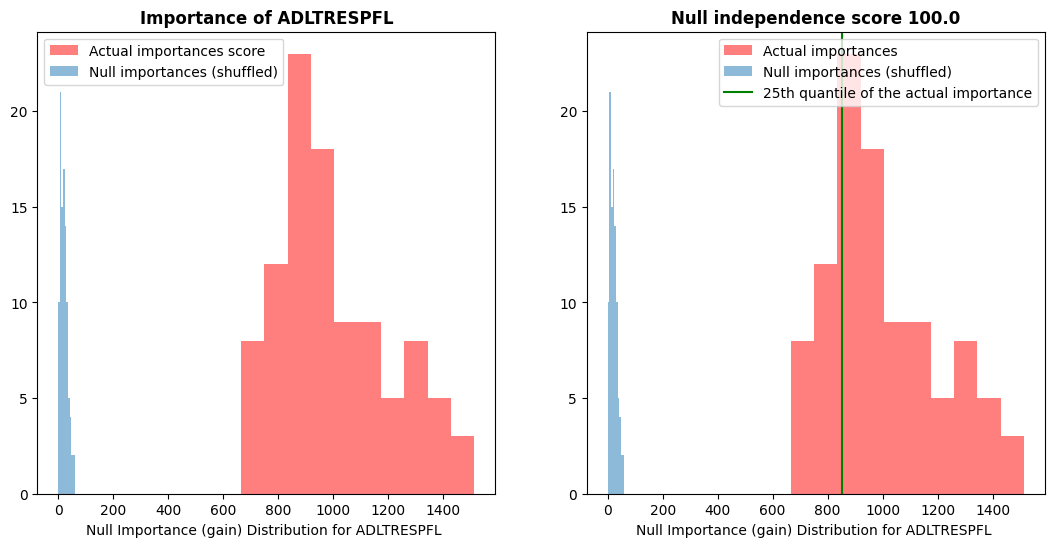

In [91]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='Adltrespfl')

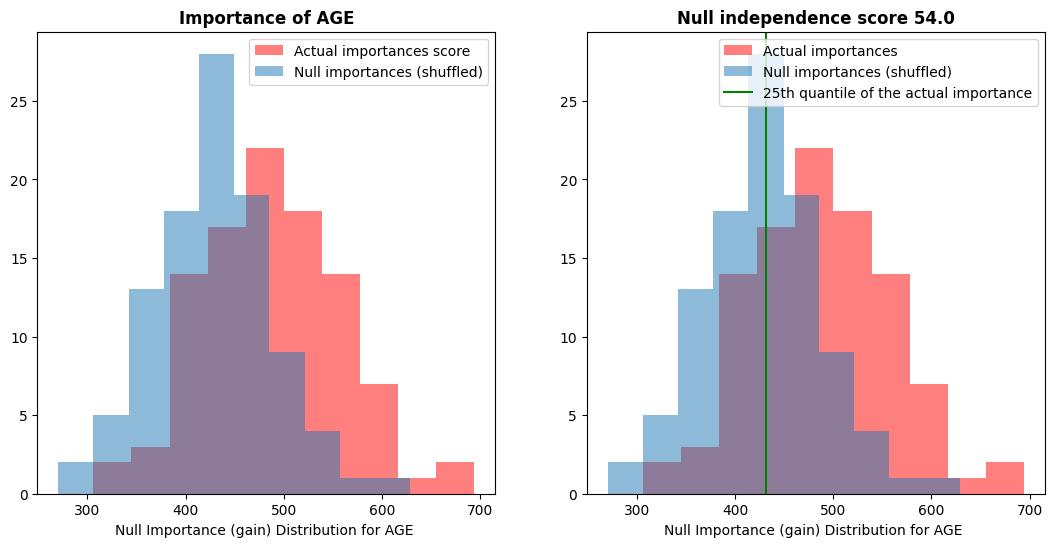

In [92]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='AGE')

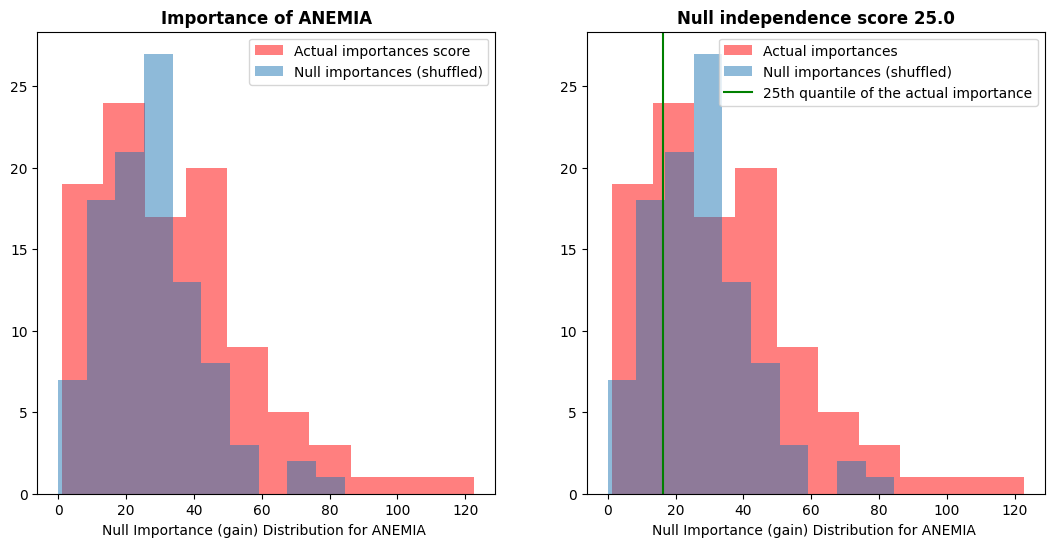

In [93]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='Anemia')

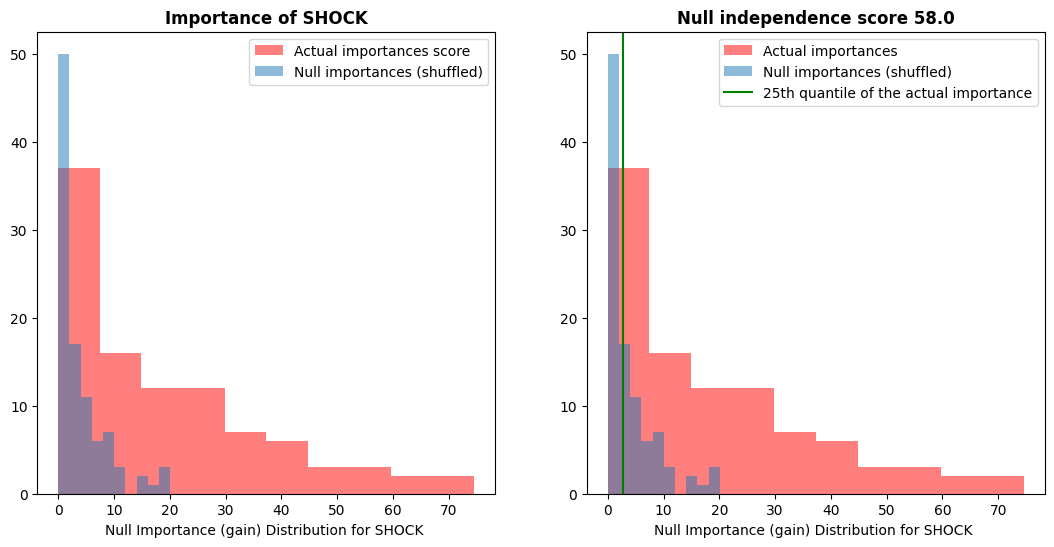

In [94]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='Shock')

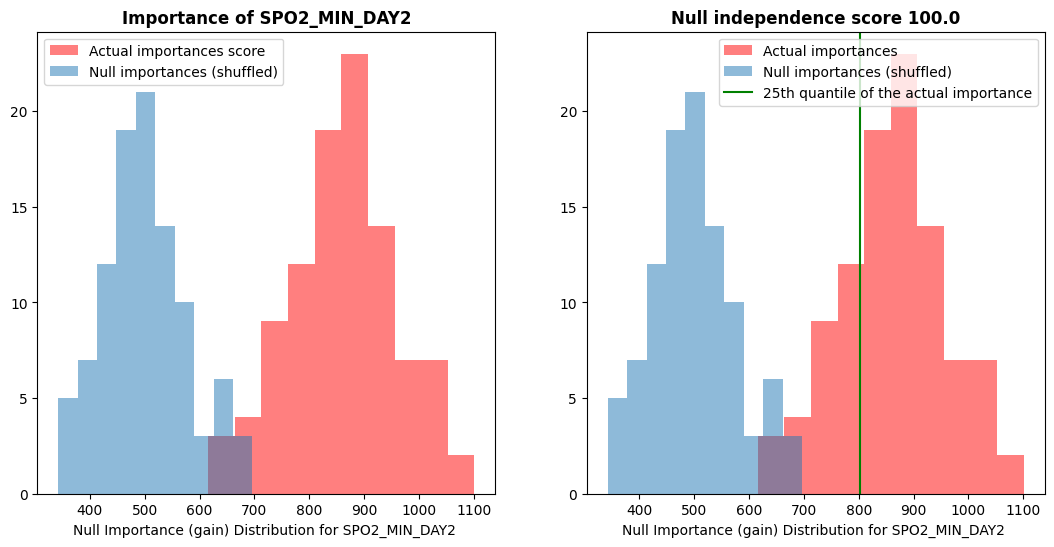

In [95]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='SPO2_MIN_DAY2')

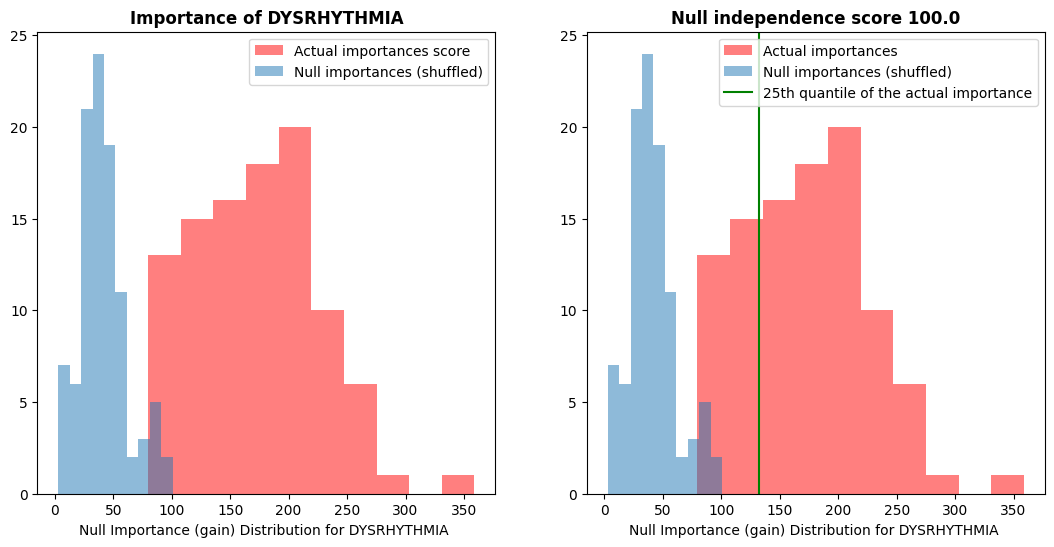

In [96]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='Dysrhythmia')

In [39]:
# null_imp_df = pd.read_csv('null_importances_distribution_rf.csv')
# actual_imp_df = pd.read_csv('actual_importances_ditribution_rf.csv')

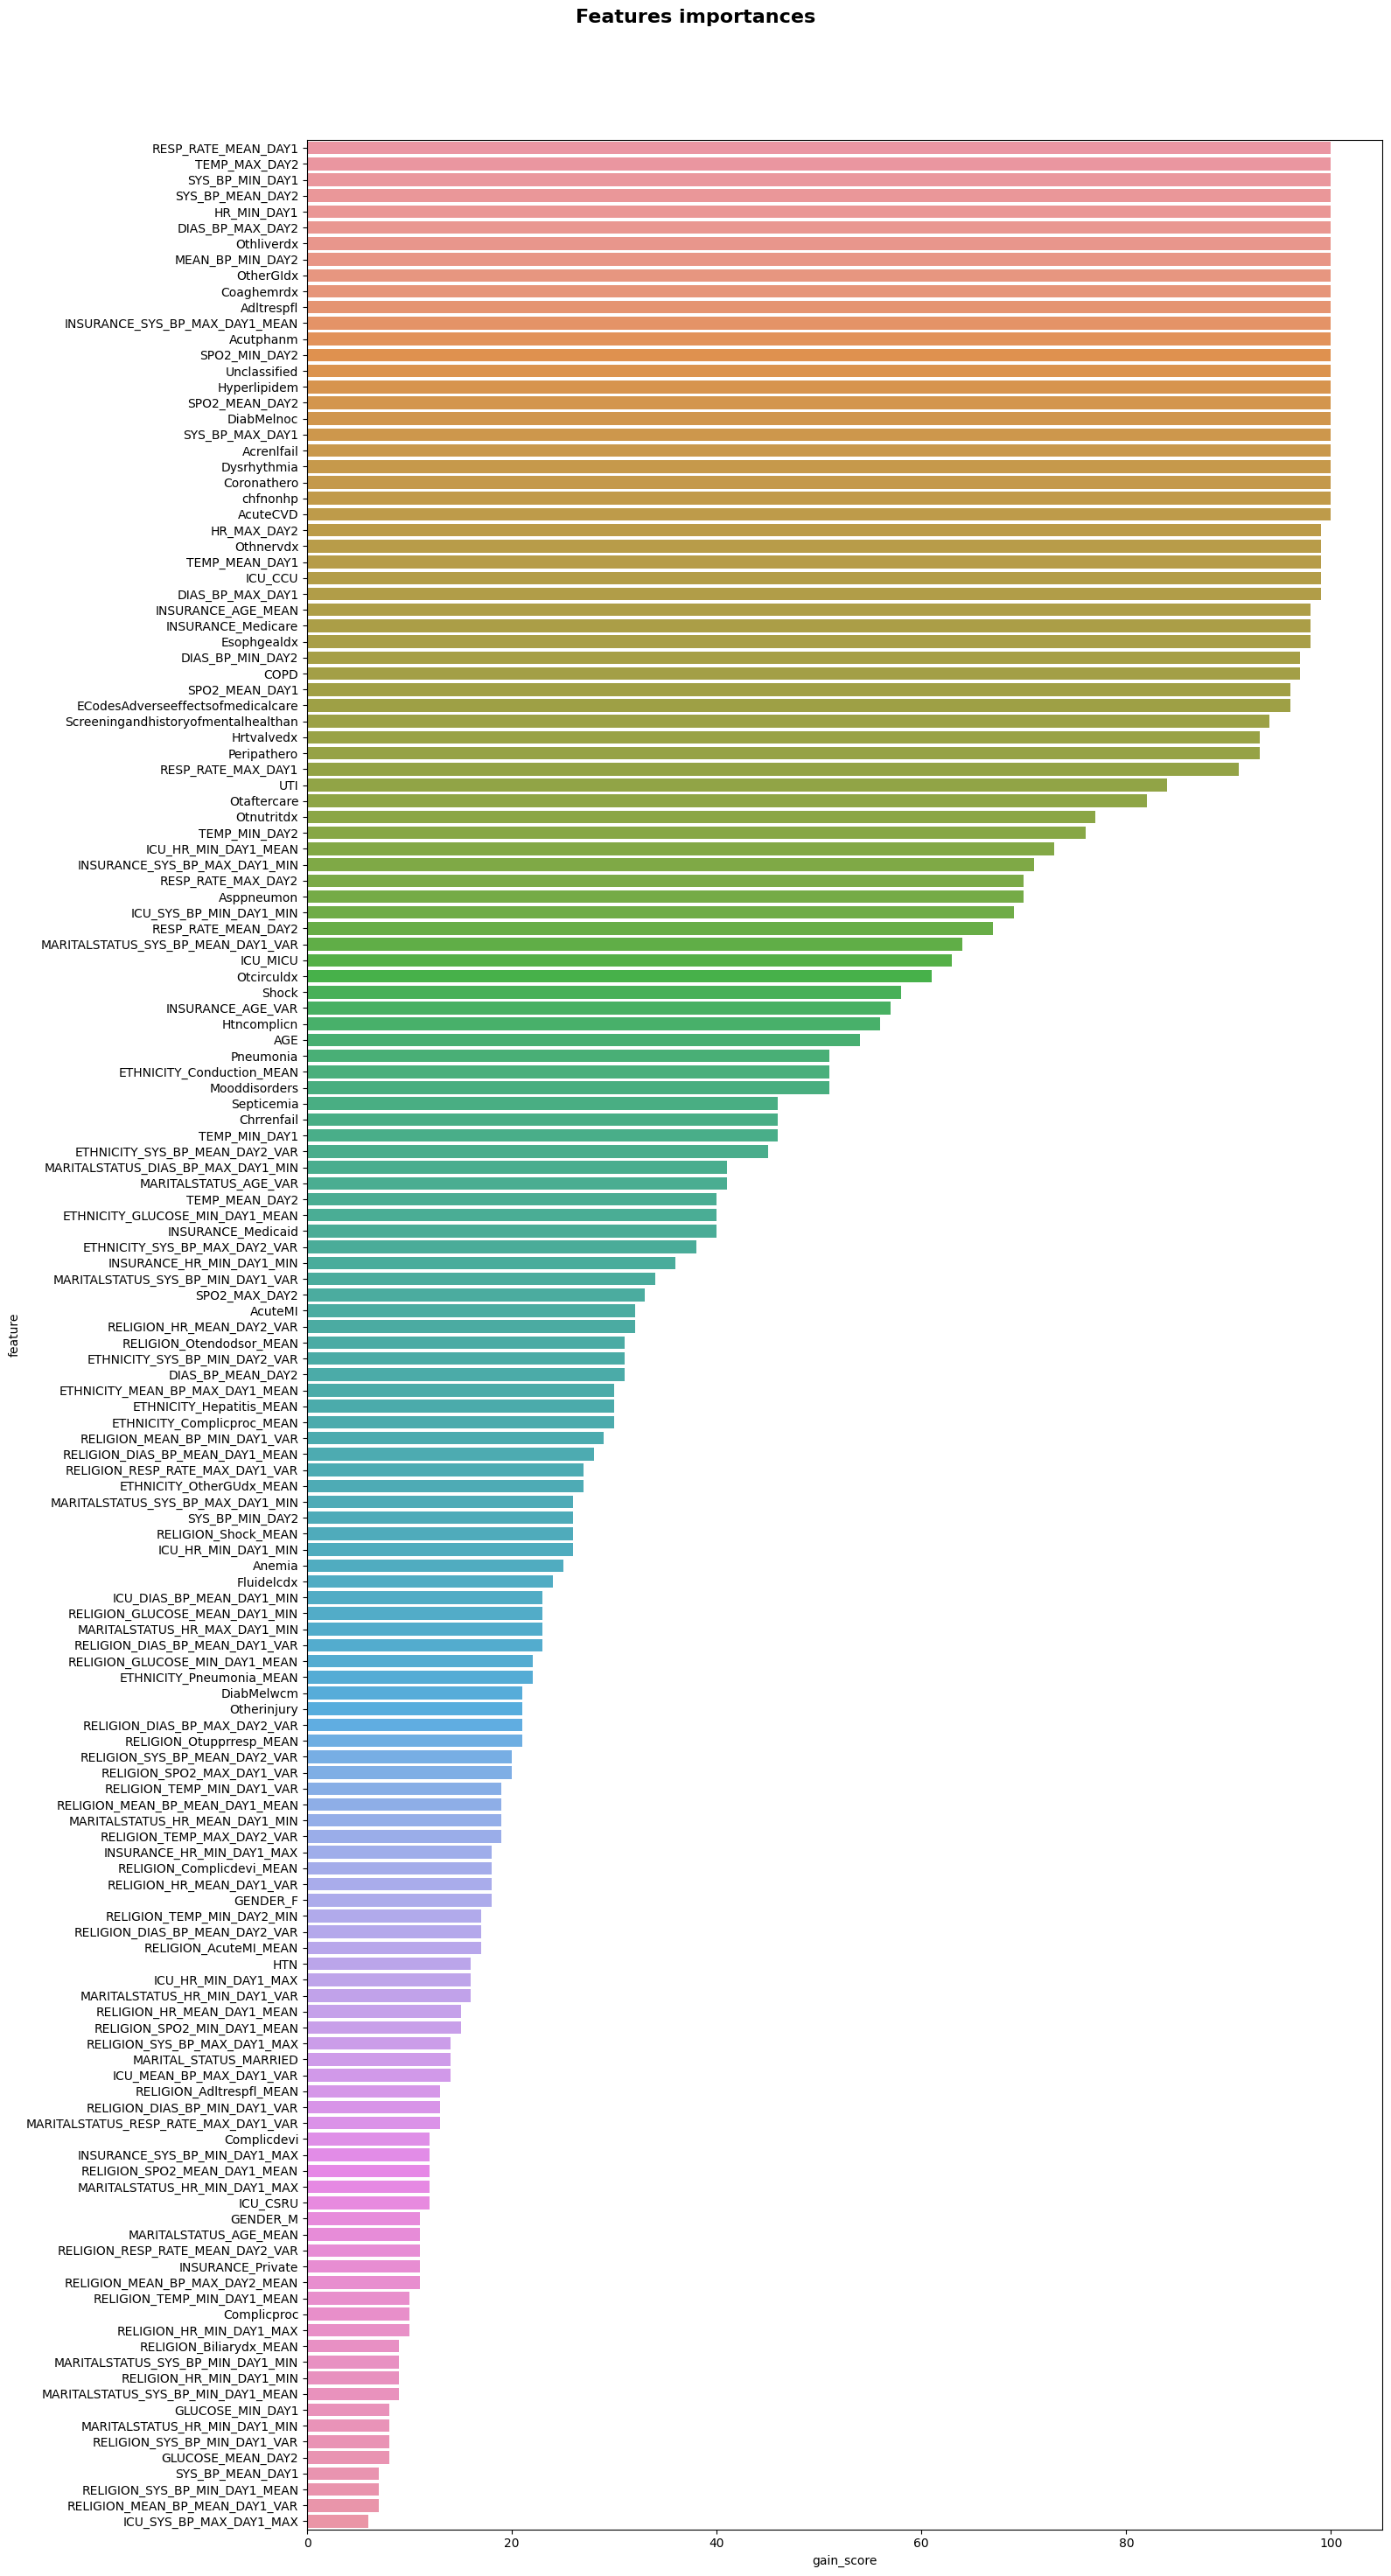

In [99]:
fig = plt.figure(figsize=(16, 30))
# gs = gridspec.GridSpec(1, 2)
# # Plot Split importances
# ax = plt.subplot(gs[0, 0])
# sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
# ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
# ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:150])
# plt.title('Feature importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features importances", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [41]:
def score_feature_selection(x_df, ys, selected_fts, selected_cat_fts):
    folds = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    X_train = x_df[selected_fts]
    y_train = ys
    splits = list(folds.split(X_train, y_train))

    y_oof = np.zeros(X_train.shape[0])

    for fold_n in range(5):
        train_index, valid_index = splits[fold_n]
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index] 

        for nestimators in range(10):
            rus = RandomUnderSampler()
            
            X_rus,y_rus = rus.fit_resample(X_tr,y_tr)
            
            dtrain = lgb.Dataset(X_rus, y_rus, free_raw_data=False)
            lgb_params = {
                    'objective': 'binary',
                    'boosting_type': 'goss',
                    'subsample': 1.0,
                    'colsample_bytree': 0.7,
                    'num_leaves': 8,
                    'max_depth': 3,
                    'n_jobs': -1,
                    'verbosity': -1,
                }
            clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)



            y_oof[valid_index] += clf.predict(X_val)  / 10
            del X_rus, y_rus
            gc.collect()   

    y_oof = (y_oof > 0.5).astype(int)

    score = metrics.balanced_accuracy_score(y_train, y_oof)  # scoring
    num_features = X_train.shape[1]
    
    return score, num_features

In [42]:
gain_results = []
gain_num_features = []
thresholds_search_space = [0, 0.01, 5, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]

for threshold in thresholds_search_space:
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in CAT_FTS)]
                                                                                             
    print(f'Results for threshold {threshold}')
    gain_score, gain_num_ft = score_feature_selection(x_df, ys, gain_feats, gain_cat_feats)
    gain_results.append(gain_score)
    gain_num_features.append(gain_num_ft)
    print('\t%d features' % (gain_num_ft))
    print('\t%.6f' % (gain_score))

Results for threshold 0
	2433 features
	0.756706
Results for threshold 0.01
	166 features
	0.760970
Results for threshold 5
	153 features
	0.755882
Results for threshold 10
	138 features
	0.755026
Results for threshold 20
	103 features
	0.755412
Results for threshold 30
	81 features
	0.753572
Results for threshold 40
	69 features
	0.753741
Results for threshold 50
	60 features
	0.754440
Results for threshold 60
	53 features
	0.749973
Results for threshold 70
	48 features
	0.749448
Results for threshold 80
	42 features
	0.746912
Results for threshold 90
	40 features
	0.747626
Results for threshold 95
	36 features
	0.744062
Results for threshold 99
	29 features
	0.742167


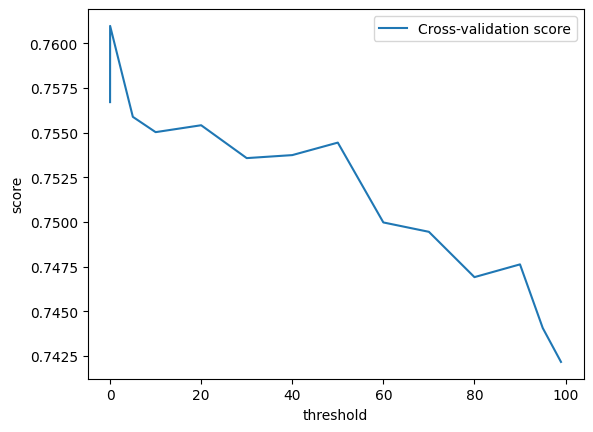

In [50]:
sns.lineplot(x=thresholds_search_space, y=gain_results, label='Cross-validation score')
plt.xlabel('threshold')
plt.ylabel('score')
plt.show()

Threshold 0.01 perform best, so we use that threshold to select the features

In [44]:
chosen_feats = [_f for _f, _, _score in correlation_scores if _score >= 0.01]
combined_chosen_feats = list(set(chosen_feats).union(set(NUMERIC_FTS)).union(set(BINARY_FTS)))
original_features = NUMERIC_FTS + BINARY_FTS
print(chosen_feats)

['AcuteMI', 'Coronathero', 'Dysrhythmia', 'chfnonhp', 'AcuteCVD', 'Peripathero', 'Otcirculdx', 'Pneumonia', 'COPD', 'Asppneumon', 'Adltrespfl', 'Esophgealdx', 'Othliverdx', 'OtherGIdx', 'Acrenlfail', 'Chrrenfail', 'UTI', 'Septicemia', 'Complicdevi', 'Complicproc', 'Otherinjury', 'Shock', 'Otaftercare', 'Unclassified', 'ECodesAdverseeffectsofmedicalcare', 'DiabMelnoc', 'DiabMelwcm', 'Hyperlipidem', 'Fluidelcdx', 'Otnutritdx', 'Anemia', 'Acutphanm', 'Coaghemrdx', 'Mooddisorders', 'Screeningandhistoryofmentalhealthan', 'Othnervdx', 'Hrtvalvedx', 'HTN', 'Htncomplicn', 'AGE', 'HR_MIN_DAY1', 'HR_MAX_DAY1', 'SYS_BP_MIN_DAY1', 'SYS_BP_MAX_DAY1', 'SYS_BP_MEAN_DAY1', 'DIAS_BP_MAX_DAY1', 'MEAN_BP_MAX_DAY1', 'RESP_RATE_MAX_DAY1', 'RESP_RATE_MEAN_DAY1', 'TEMP_MIN_DAY1', 'TEMP_MAX_DAY1', 'TEMP_MEAN_DAY1', 'SPO2_MEAN_DAY1', 'GLUCOSE_MIN_DAY1', 'GLUCOSE_MAX_DAY1', 'HR_MAX_DAY2', 'HR_MEAN_DAY2', 'SYS_BP_MIN_DAY2', 'SYS_BP_MEAN_DAY2', 'DIAS_BP_MIN_DAY2', 'DIAS_BP_MAX_DAY2', 'DIAS_BP_MEAN_DAY2', 'MEAN_BP

In [64]:
import pickle
with open('pickle/chosen_feats_final.pkl', 'wb') as handle:
    pickle.dump(chosen_feats, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 5. Classification models

Train the model

### Code: Cross-validation

Use cross-validation (to get a more reliable estimate) combined with an exploration of hyperparameters (to improve results).

Here I use the default parameters for LGBM classifier


<center>
<img src="resources/lgbm.png" width="1200" height="600">
</center>


In [67]:
MODEL_NAME = 'LGBMClassifier'
NFOLDS = 3
NESTIMATORS = 10

In [68]:
folds = RepeatedStratifiedKFold(n_splits=NFOLDS, n_repeats=1, random_state=1)
X_train = x_df[combined_chosen_feats]
y_train = ys
splits = list(folds.split(X_train, y_train))
X_test = x_test_df[combined_chosen_feats]

print(f"Training {MODEL_NAME}")
y_preds = np.zeros((NFOLDS, X_test.shape[0],NESTIMATORS))
y_oof = np.zeros((X_train.shape[0],NESTIMATORS))

for fold_n in range(NFOLDS):
    train_index, valid_index = splits[fold_n]
    print(f"Fold {fold_n}")
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = ys.iloc[train_index], ys.iloc[valid_index]  
    
    for nestimators in tqdm.tqdm(range(NESTIMATORS)):
        rus = RandomUnderSampler()
        
        X_rus,y_rus = rus.fit_resample(X_tr,y_tr)

        dtrain = lgb.Dataset(X_rus, y_rus, free_raw_data=False)
        lgb_params = {
                'n_jobs': -1,
                'verbosity': -1,
            }
        clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

        y_pred_valid = clf.predict(X_val) 
        y_oof[valid_index, nestimators] = y_pred_valid
        del X_rus, y_rus
        gc.collect()   

    del X_tr, X_val, y_tr, y_val
    gc.collect() 
y_oof = np.mean(y_oof, axis=-1)
y_oof = (y_oof > 0.5).astype(int)

y_oof_orig_model = y_oof

print('Cross-validation score:')
metrics.balanced_accuracy_score(y_train, y_oof)

Training LGBMClassifier
Fold 0


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Fold 1


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Fold 2


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]

Cross-validation score:


0.7591243854823525

Next I will do the hyperparameters search for:
- n_estimators: 5, 10, 20, 50, 100
- max_depth: 3, 8, 20
- features_selection_strategy: 'original_features', 'combined_chosen_feats', or 'chosen_feats'

In [78]:
print(f"Training {MODEL_NAME}")

all_model_performance = {}
for NESTIMATORS in [10, 50, 100]:
    for MAX_DEPTH in [3, 8, 12]:
        for features_selection_strategy in ['original_features', 'combined_chosen_feats', 'chosen_feats']:
            if features_selection_strategy == 'original_features':
                CHOSEN_FEATURES = original_features
            elif features_selection_strategy == 'combined_chosen_feats':
                CHOSEN_FEATURES = combined_chosen_feats
            elif features_selection_strategy == 'chosen_feats':
                CHOSEN_FEATURES = chosen_feats
            else:
                raise NotImplementedError
            print(f'Training n_estimators:{NESTIMATORS}, depth:{MAX_DEPTH}, features_selection_strategy:{features_selection_strategy}')
            y_preds = np.zeros((NFOLDS, X_test.shape[0],NESTIMATORS))
            y_oof = np.zeros((X_train.shape[0],NESTIMATORS))

            for fold_n in range(NFOLDS):
                train_index, valid_index = splits[fold_n]
                X_tr, X_val = X_train.iloc[train_index][CHOSEN_FEATURES], X_train.iloc[valid_index][CHOSEN_FEATURES]
                y_tr, y_val = ys.iloc[train_index], ys.iloc[valid_index]  
                
                for nestimators in tqdm.tqdm(range(NESTIMATORS)):
                    rus = RandomUnderSampler()
                    
                    X_rus,y_rus = rus.fit_resample(X_tr,y_tr)

                    dtrain = lgb.Dataset(X_rus, y_rus, free_raw_data=False)
                    lgb_params = {
                            'max_depth': MAX_DEPTH,
                            'n_jobs': -1,
                            'verbosity': -1,
                        }
                    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

                    y_pred_valid = clf.predict(X_val) 
                    y_oof[valid_index, nestimators] = y_pred_valid
                    del X_rus, y_rus
                    gc.collect()   

                del X_tr, X_val, y_tr, y_val
                gc.collect() 
            y_oof = np.mean(y_oof, axis=-1)
            y_oof = (y_oof > 0.5).astype(int)

            all_model_performance[f'n_estimator:{NESTIMATORS}, depth:{MAX_DEPTH}, features_selection_strategy:{features_selection_strategy}'] = {
                'score':metrics.balanced_accuracy_score(y_train, y_oof), 
                'y_oof': y_oof
            }

Training LGBMClassifier
Training n_estimators:10, depth:3, features_selection_strategy:original_features


100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


Training n_estimators:10, depth:3, features_selection_strategy:combined_chosen_feats


100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Training n_estimators:10, depth:3, features_selection_strategy:chosen_feats


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Training n_estimators:10, depth:8, features_selection_strategy:original_features


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Training n_estimators:10, depth:8, features_selection_strategy:combined_chosen_feats


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Training n_estimators:10, depth:8, features_selection_strategy:chosen_feats


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Training n_estimators:10, depth:12, features_selection_strategy:original_features


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Training n_estimators:10, depth:12, features_selection_strategy:combined_chosen_feats


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Training n_estimators:10, depth:12, features_selection_strategy:chosen_feats


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Training n_estimators:50, depth:3, features_selection_strategy:original_features


100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Training n_estimators:50, depth:3, features_selection_strategy:combined_chosen_feats


100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


Training n_estimators:50, depth:3, features_selection_strategy:chosen_feats


100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


Training n_estimators:50, depth:8, features_selection_strategy:original_features


100%|██████████| 50/50 [00:38<00:00,  1.28it/s]


Training n_estimators:50, depth:8, features_selection_strategy:combined_chosen_feats


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Training n_estimators:50, depth:8, features_selection_strategy:chosen_feats


100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


Training n_estimators:50, depth:12, features_selection_strategy:original_features


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Training n_estimators:50, depth:12, features_selection_strategy:combined_chosen_feats


100%|██████████| 50/50 [00:54<00:00,  1.08s/it]


Training n_estimators:50, depth:12, features_selection_strategy:chosen_feats


100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Training n_estimators:100, depth:3, features_selection_strategy:original_features


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Training n_estimators:100, depth:3, features_selection_strategy:combined_chosen_feats


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Training n_estimators:100, depth:3, features_selection_strategy:chosen_feats


100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


Training n_estimators:100, depth:8, features_selection_strategy:original_features


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


Training n_estimators:100, depth:8, features_selection_strategy:combined_chosen_feats


100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


Training n_estimators:100, depth:8, features_selection_strategy:chosen_feats


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


Training n_estimators:100, depth:12, features_selection_strategy:original_features


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Training n_estimators:100, depth:12, features_selection_strategy:combined_chosen_feats


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Training n_estimators:100, depth:12, features_selection_strategy:chosen_feats


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


In [79]:
max_score = 0
max_score_hyperparams = ''
max_score_y_oof = None
for k,v in all_model_performance.items():
    if v['score'] > max_score:
        max_score = v['score']
        max_score_hyperparams = k
        max_score_y_oof = v['y_oof']
print(f'Max score: {max_score:.4f} with hyperparameters:')
print(max_score_hyperparams)

Max score: 0.7646 with hyperparameters:
n_estimator:50, depth:12, features_selection_strategy:chosen_feats


<span style="color:red">Implement your solution below</span>

* **For 2 of the models** (at least 1 other than the proposed baseline):

    * For different values of one of the hyperparameters, give the average `balanced_accuracy` of the cross-validation in the form of Boxplots (or bar graph with an error bar): see the example presented in the graph below.
    
    * Briefly explain what observations to draw concerning the stability of the predictions.

![](img/boxplot-cv.png)

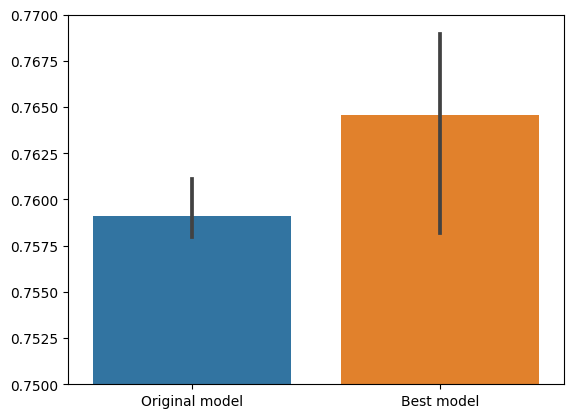

In [80]:
CV_scores = []
model_names = []

for fold_n in range(NFOLDS):
    train_index, valid_index = splits[fold_n]
    y_val = ys.iloc[valid_index]  
    y_oof_orig_model_this_fold = y_oof_orig_model[valid_index]
    CV_scores.append(metrics.balanced_accuracy_score(y_val, y_oof_orig_model_this_fold))
    model_names.append('Original model')

    max_score_y_oof_this_fold = max_score_y_oof[valid_index]
    CV_scores.append(metrics.balanced_accuracy_score(y_val, max_score_y_oof_this_fold))
    model_names.append('Best model')

sns.barplot(x=model_names, y=CV_scores)
plt.ylim([0.75, 0.77])
plt.show()

<span style="color:red">Implement your solution below</span>

* **For each of these 2 models, from the validation data created previously** (`x_valid`,` y_valid`):

    * Measure the area under the ROC curve (AUC) using the Scikit-Learn (`roc_auc_score`) function and compare the models with their respective combination of hyperparameters giving the best result.

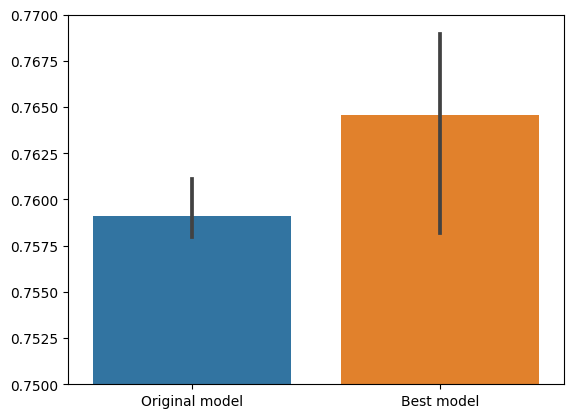

In [83]:
CV_scores = []
model_names = []

for fold_n in range(NFOLDS):
    train_index, valid_index = splits[fold_n]
    y_val = ys.iloc[valid_index]  
    y_oof_orig_model_this_fold = y_oof_orig_model[valid_index]
    CV_scores.append(metrics.roc_auc_score(y_val, y_oof_orig_model_this_fold))
    model_names.append('Original model')

    max_score_y_oof_this_fold = max_score_y_oof[valid_index]
    CV_scores.append(metrics.roc_auc_score(y_val, max_score_y_oof_this_fold))
    model_names.append('Best model')

sns.barplot(x=model_names, y=CV_scores)
plt.ylim([0.75, 0.77])
plt.show()

<span style="color:red">Implement your solution below</span>

* **For the model and its combination of hyperparameters offering the best result**:

    * Present the confusion matrix and describe it succinctly.

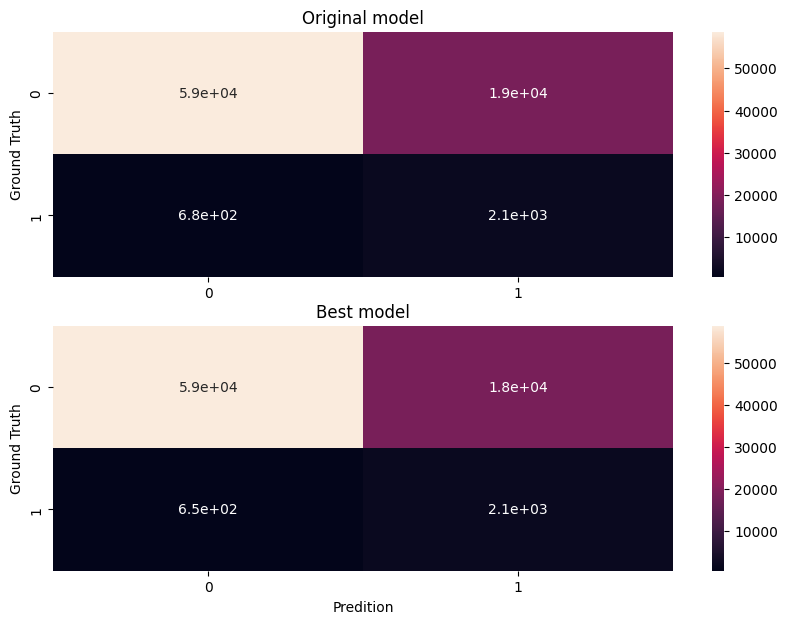

In [89]:
plt.figure(figsize = (10,7))
plt.subplot(211)
confusion_matrix_orig = metrics.confusion_matrix(y_train, y_oof_orig_model, labels=[0, 1])
df_cm_orig = pd.DataFrame(confusion_matrix_orig, index = [0, 1],
                  columns = [0, 1])
sns.heatmap(df_cm_orig, annot=True)
plt.ylabel('Ground Truth')
plt.title('Original model')
plt.subplot(212)
confusion_matrix_best = metrics.confusion_matrix(y_train, max_score_y_oof, labels=[0, 1])
df_cm_best = pd.DataFrame(confusion_matrix_best, index = [0, 1],
                  columns = [0, 1])
sns.heatmap(df_cm_best, annot=True)
plt.xlabel('Predition')
plt.ylabel('Ground Truth')
plt.title('Best model')
plt.show()

### Code: Try to improve your score

<span style="color:red">Implement your solution below</span>

Here instead of a simple RandomForestClassifier, we trained 3 different models:
- XGBoost
- LightGBM
- CatBoost
  
Then we will use a RidgeClassifier to stack the predictions with alpha=1.0 to prevent overfitting

In [ ]:
MODEL_NAMES = ['XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']
STACKING_MODEL = 'RidgeClassifier'
NFOLDS = 5
NSEEDS = 3
NESTIMATORS = 50
NESTIMATORS_STACK = 100

In [ ]:
folds = RepeatedStratifiedKFold(n_splits=NFOLDS, n_repeats=NSEEDS, random_state=1)
X_train = x_df[combined_chosen_feats]
y_train = ys
splits = list(folds.split(X_train, y_train))
X_test = x_test_df[combined_chosen_feats]

all_y_preds = []
all_y_oof = []

for MODEL_NAME in MODEL_NAMES:
    print(f"Training {MODEL_NAME}")
    y_preds = np.zeros((NFOLDS, X_test.shape[0],NSEEDS*NESTIMATORS))
    y_oof = np.zeros((X_train.shape[0],NSEEDS*NESTIMATORS))
    train_accs = []
    for repeat_n in range(NSEEDS):
        for fold_n in range(NFOLDS):
            train_index, valid_index = splits[NSEEDS*repeat_n + fold_n]
            print(f"Fold {fold_n}, repeat {repeat_n}")
            X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
            y_tr, y_val = ys.iloc[train_index], ys.iloc[valid_index]  
            
            y_preds_tr = np.zeros(X_tr.shape[0])
            y_preds_val = np.zeros(X_val.shape[0])
            
            # ADD TRAIN ERROR
            for nestimators in tqdm.tqdm(range(NESTIMATORS)):
                rus = RandomUnderSampler()
                
                X_rus,y_rus = rus.fit_resample(X_tr,y_tr)

                if 'ensemble' in str(str_to_class(MODEL_NAME)).split('.'):
                    clf = str_to_class(MODEL_NAME)(n_estimators=1)
                elif MODEL_NAME=='XGBClassifier':
                    clf = str_to_class(MODEL_NAME)(tree_method="hist", enable_categorical=True)
                elif MODEL_NAME=='LGBMClassifier':
                    dtrain = lgb.Dataset(X_rus, y_rus, free_raw_data=False)
                    lgb_params = {
                        'n_jobs': -1,
                        'verbosity': -1,
                    }
                    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)
                elif MODEL_NAME=='CatBoostClassifier':
                    clf = str_to_class(MODEL_NAME)()
                else:
                    clf = str_to_class(MODEL_NAME)()

                if MODEL_NAME=='LGBMClassifier':
                    pass
                elif MODEL_NAME=='CatBoostClassifier':
                    clf.fit(X_rus.to_numpy(), y_rus.to_numpy(), verbose=0)
                else:
                    clf.fit(X_rus, y_rus)
                y_preds_tr += clf.predict(X_tr)/NESTIMATORS

                y_pred_valid = clf.predict(X_val) 
                y_preds_val += y_pred_valid/NESTIMATORS
                y_oof[valid_index, NSEEDS*repeat_n + nestimators] = y_pred_valid
                y_preds[fold_n, :, NSEEDS*repeat_n + nestimators] = clf.predict(X_test)
                del X_rus, y_rus
                gc.collect()   

            y_preds_tr = (y_preds_tr > 0.5).astype(int)
            y_preds_val = (y_preds_val > 0.5).astype(int)
            val_acc = metrics.balanced_accuracy_score(y_val, y_preds_val)
            train_acc = metrics.balanced_accuracy_score(y_tr, y_preds_tr)
            print(f"Val balanced accuracy score: {val_acc:.3g}")
            print(f"Train balanced accuracy score: {train_acc:.3g}")

            train_accs.append(train_acc)

            del X_tr, X_val, y_tr, y_val
            gc.collect() 

    all_y_preds.append(y_preds)
    all_y_oof.append(y_oof)

Training XGBClassifier
Fold 0, repeat 0


100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


Val balanced accuracy score: 0.765
Train balanced accuracy score: 0.886
Fold 1, repeat 0


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Val balanced accuracy score: 0.774
Train balanced accuracy score: 0.885
Fold 2, repeat 0


100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


Val balanced accuracy score: 0.768
Train balanced accuracy score: 0.885
Fold 3, repeat 0


100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Val balanced accuracy score: 0.764
Train balanced accuracy score: 0.886
Fold 4, repeat 0


100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


Val balanced accuracy score: 0.76
Train balanced accuracy score: 0.885
Fold 0, repeat 1


100%|██████████| 50/50 [01:02<00:00,  1.26s/it]


Val balanced accuracy score: 0.764
Train balanced accuracy score: 0.887
Fold 1, repeat 1


100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


Val balanced accuracy score: 0.76
Train balanced accuracy score: 0.886
Fold 2, repeat 1


100%|██████████| 50/50 [01:05<00:00,  1.30s/it]


Val balanced accuracy score: 0.763
Train balanced accuracy score: 0.885
Fold 3, repeat 1


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


Val balanced accuracy score: 0.763
Train balanced accuracy score: 0.886
Fold 4, repeat 1


100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


Val balanced accuracy score: 0.764
Train balanced accuracy score: 0.885
Fold 0, repeat 2


100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Val balanced accuracy score: 0.76
Train balanced accuracy score: 0.886
Fold 1, repeat 2


100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


Val balanced accuracy score: 0.76
Train balanced accuracy score: 0.887
Fold 2, repeat 2


100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


Val balanced accuracy score: 0.764
Train balanced accuracy score: 0.885
Fold 3, repeat 2


100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


Val balanced accuracy score: 0.768
Train balanced accuracy score: 0.883
Fold 4, repeat 2


100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


Val balanced accuracy score: 0.762
Train balanced accuracy score: 0.885
Training LGBMClassifier
Fold 0, repeat 0


100%|██████████| 50/50 [03:20<00:00,  4.00s/it]


Val balanced accuracy score: 0.767
Train balanced accuracy score: 0.893
Fold 1, repeat 0


100%|██████████| 50/50 [03:20<00:00,  4.01s/it]


Val balanced accuracy score: 0.77
Train balanced accuracy score: 0.89
Fold 2, repeat 0


100%|██████████| 50/50 [03:09<00:00,  3.80s/it]


Val balanced accuracy score: 0.768
Train balanced accuracy score: 0.891
Fold 3, repeat 0


100%|██████████| 50/50 [03:10<00:00,  3.81s/it]


Val balanced accuracy score: 0.767
Train balanced accuracy score: 0.892
Fold 4, repeat 0


100%|██████████| 50/50 [03:12<00:00,  3.85s/it]


Val balanced accuracy score: 0.758
Train balanced accuracy score: 0.891
Fold 0, repeat 1


100%|██████████| 50/50 [03:10<00:00,  3.82s/it]


Val balanced accuracy score: 0.77
Train balanced accuracy score: 0.892
Fold 1, repeat 1


100%|██████████| 50/50 [03:11<00:00,  3.83s/it]


Val balanced accuracy score: 0.757
Train balanced accuracy score: 0.892
Fold 2, repeat 1


100%|██████████| 50/50 [42:23<00:00, 50.87s/it]   


Val balanced accuracy score: 0.764
Train balanced accuracy score: 0.893
Fold 3, repeat 1


100%|██████████| 50/50 [02:04<00:00,  2.50s/it]


Val balanced accuracy score: 0.761
Train balanced accuracy score: 0.892
Fold 4, repeat 1


100%|██████████| 50/50 [01:53<00:00,  2.26s/it]


Val balanced accuracy score: 0.754
Train balanced accuracy score: 0.891
Fold 0, repeat 2


100%|██████████| 50/50 [01:53<00:00,  2.26s/it]


Val balanced accuracy score: 0.763
Train balanced accuracy score: 0.892
Fold 1, repeat 2


100%|██████████| 50/50 [01:54<00:00,  2.30s/it]


Val balanced accuracy score: 0.76
Train balanced accuracy score: 0.892
Fold 2, repeat 2


100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


Val balanced accuracy score: 0.766
Train balanced accuracy score: 0.89
Fold 3, repeat 2


100%|██████████| 50/50 [01:51<00:00,  2.23s/it]


Val balanced accuracy score: 0.768
Train balanced accuracy score: 0.891
Fold 4, repeat 2


100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


Val balanced accuracy score: 0.762
Train balanced accuracy score: 0.891
Training CatBoostClassifier
Fold 0, repeat 0


100%|██████████| 50/50 [04:04<00:00,  4.88s/it]


Val balanced accuracy score: 0.761
Train balanced accuracy score: 0.866
Fold 1, repeat 0


100%|██████████| 50/50 [04:10<00:00,  5.01s/it]


Val balanced accuracy score: 0.763
Train balanced accuracy score: 0.863
Fold 2, repeat 0


100%|██████████| 50/50 [04:12<00:00,  5.05s/it]


Val balanced accuracy score: 0.762
Train balanced accuracy score: 0.865
Fold 3, repeat 0


100%|██████████| 50/50 [04:15<00:00,  5.11s/it]


Val balanced accuracy score: 0.767
Train balanced accuracy score: 0.867
Fold 4, repeat 0


100%|██████████| 50/50 [04:18<00:00,  5.17s/it]


Val balanced accuracy score: 0.758
Train balanced accuracy score: 0.863
Fold 0, repeat 1


100%|██████████| 50/50 [04:26<00:00,  5.34s/it]


Val balanced accuracy score: 0.763
Train balanced accuracy score: 0.866
Fold 1, repeat 1


100%|██████████| 50/50 [04:37<00:00,  5.55s/it]


Val balanced accuracy score: 0.759
Train balanced accuracy score: 0.863
Fold 2, repeat 1


100%|██████████| 50/50 [04:42<00:00,  5.66s/it]


Val balanced accuracy score: 0.759
Train balanced accuracy score: 0.864
Fold 3, repeat 1


100%|██████████| 50/50 [04:42<00:00,  5.65s/it]


Val balanced accuracy score: 0.758
Train balanced accuracy score: 0.863
Fold 4, repeat 1


100%|██████████| 50/50 [04:49<00:00,  5.80s/it]


Val balanced accuracy score: 0.756
Train balanced accuracy score: 0.865
Fold 0, repeat 2


100%|██████████| 50/50 [04:49<00:00,  5.79s/it]


Val balanced accuracy score: 0.756
Train balanced accuracy score: 0.865
Fold 1, repeat 2


100%|██████████| 50/50 [04:51<00:00,  5.83s/it]


Val balanced accuracy score: 0.758
Train balanced accuracy score: 0.867
Fold 2, repeat 2


100%|██████████| 50/50 [04:52<00:00,  5.85s/it]


Val balanced accuracy score: 0.767
Train balanced accuracy score: 0.864
Fold 3, repeat 2


100%|██████████| 50/50 [04:50<00:00,  5.81s/it]


Val balanced accuracy score: 0.764
Train balanced accuracy score: 0.863
Fold 4, repeat 2


100%|██████████| 50/50 [04:51<00:00,  5.82s/it]

Val balanced accuracy score: 0.762
Train balanced accuracy score: 0.863


In [ ]:
all_y_oof = np.concatenate(all_y_oof, axis=-1)
all_y_preds = np.concatenate(all_y_preds, axis=-1)

In [ ]:
# Ridge stacking
y_stk_val = np.zeros(X_train.shape[0])
y_stk_test = np.zeros(X_test.shape[0])
for nestimators in tqdm.tqdm(range(NESTIMATORS_STACK)):
    rus = RandomUnderSampler()
    X_rus,y_rus = rus.fit_resample(all_y_oof,y_train)

    stk = RidgeClassifier(alpha=0.1)
    stk.fit(X_rus, y_rus)
    y_stk_val += stk.predict(all_y_oof) / NESTIMATORS_STACK
    for all_y_pred in all_y_preds:
        y_stk_test += stk.predict(all_y_pred) / (NESTIMATORS_STACK * NFOLDS)
y_stk_val = (y_stk_val > 0.5).astype(int)
y_stk_test = (y_stk_test > 0.5).astype(int)
score = metrics.balanced_accuracy_score(y_train, y_stk_val)  # scoring
print(f"Overall OOF balanced accuracy score: {score:.3g}")

100%|██████████| 100/100 [00:44<00:00,  2.24it/s]

Overall OOF balanced accuracy score: 0.767


### Explanation of what you have achieved, conclusion and perspectives

What worked:
- Under Sampling to balance the training data
- Choosing important features using Null Feature importance + feature engineering
- XGBoost, LightGBM, CatBoost
- Stacking with RidgeClassifier(alpha=1)

What didn't work:
- Train the model without resample the data
- Combine different binary columns into one column with SUM (overfit)
- Feature engineering without feature selection (drop performance to around 0.68+)
- RandomForestClassifier, SVM, linear models (underfit)
- Stacking with tree models or linear model without regularization (overfit)

We use manual Grid Search to choose the hyperparameters.

Training time (5 folds 3 seeds):
- XGBoost: 15 minutes
- LightGBM: 30 minutes
- CatBoost: 1 hour

If we had more time, we will find more way to feature engineer by understand the domain even more, that would be the best approach since our model seems to reach the limit.

## 7. Save the model predictions

SUBMIT THIS AND WE GOT 0.77!!!

In [ ]:
predictions = y_stk_test  # compute predictions
PRED_PATH = Path("Submissions")
PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions/submission_2022-12-08T10-59-14.zip


---

# Note on the dataset

The dataset does not contain actual medical data. It is not allowed to share these **confidential data** from ICU patients. To avoid this problem, the data have been replaced with **artificial data**.

To have credible data, they were generated using a generative adversarial network (**GAN**) Wasserstein.

For more information: <br/>
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, et al. [Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document). ESANN 2019 - European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, Apr 2019, Bruges, Belgium.

---